In [1]:
# data
import numpy as np
import pandas as pd
import vertica_python
import sqlalchemy as sa

# visualization
import matplotlib.pyplot as plt 
plt.style.use(u'ggplot')
%matplotlib inline

In [2]:
# engine_info = "vertica+vertica_python://" + conn_info['user'] + ":" + conn_info['password'] + "@" + "vertica.getbux.com" + ":5433/" + conn_info['database'] 
# engine = sa.create_engine(engine_info)


# cur = connection.cursor()
# cur.execute("SELECT * FROM TABLE")
# result = cur.fetchall()
# connection.close()

# from sqlalchemy.engine import url as sa_url
# from sqlalchemy import create_engine
# db_connect_url = sa_url.URL(
#             drivername='vertica+pyodbc',
#             username='josolnik',
#             password='CXw!CHeDa@N6hGQ8',
#             host='vertica.getbux.com',
#             port=5433,
#             database='buxdwh',
# )
# create_engine(db_connect_url)

In [140]:
conn_info = {'host': 'vertica.getbux.com',
              'port': 5433,
              'user': 'josolnik',
              'password': 'CXw!CHeDa@N6hGQ8',
              'database': 'buxdwh',
              # 10 minutes timeout on queries
              'read_timeout': 600,
              # default throw error on invalid UTF-8 results
              'unicode_error': 'strict',
              # SSL is disabled by default
              'ssl': False,
              'connection_timeout': 5
              # connection timeout is not enabled by default
           }

# simple connection, with manual close


conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

In [139]:
def sql_query(query_string): # columns):
    cur.execute(query_string)
    df = pd.DataFrame(cur.fetchall())
    # df.columns = columns
    return df

# Queries

### Users

In [6]:
user_columns = ['user_id', 'country_cd', 'gender', 'nationality', 'platform_type_name', 'trading_experience', 'title', 'network', 'bux_account_created_dts', 'account_type', 'ams_first_funded_dts', 'initial_deposit_amount', 'sum_deposits', 'cnt_deposits']

query_users_large = """ 

        SELECT user_id, country_cd, gender, nationality, platform_type_name, trading_experience, title, network, bux_account_created_dts, account_type, ams_first_funded_dts, initial_deposit_amount, sum_deposits, cnt_deposits
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2016-09-30' AND '2017-09-30'

        """
users_large = sql_query(query_users_large)
# users.columns = user_columns

In [60]:
user_columns = ['user_id', 'country_cd', 'gender', 'nationality', 'platform_type_name', 'trading_experience', 'title', 'network', 'bux_account_created_dts', 'account_type', 'ams_first_funded_dts', 'initial_deposit_amount', 'sum_deposits', 'cnt_deposits']

query_users = """ 

        SELECT user_id, country_cd, gender, nationality, platform_type_name, trading_experience, title, network, bux_account_created_dts, account_type, ams_first_funded_dts, initial_deposit_amount, sum_deposits, cnt_deposits
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-03-01'

        """
users = sql_query(query_users)
# users.columns = user_columns

In [61]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,010e236f-8ab5-4681-a146-273531d19d54,AT,None,None,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaT,None,None,NaN
1,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,None,None,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaT,None,None,NaN
2,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaT,None,None,NaN
3,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaT,None,None,NaN
4,031eedbe-8154-4032-b9b7-157ac8131669,AT,None,None,Android,NONE,Rookie Trader,Organic,2017-02-12 12:26:43.838,FUN_BUX,NaT,None,None,NaN


In [27]:
users.to_csv('data/users_Feb_1_30days_cohort.csv')

In [ ]:
users_large.to_csv("data/users_1y_6mCustomerValue.csv")

In [10]:
567178 / 100

5671.78

In [8]:
len(users_large)

567178

In [28]:
len(users)

58839

### USERS EDA

In [29]:
def column_summary(column_name, limit=False):
    if limit:
        df = pd.DataFrame(users[column_name].value_counts()).sort_values(by=column_name, ascending=False)[0:limit]
        plot = df.plot(kind='bar')
        return plot, df

,sum_deposits
50.0000000,756
100.0000000,354
150.0000000,131
200.0000000,107
250.0000000,76
300.0000000,65
500.0000000,64
350.0000000,38
400.0000000,36
1000.0000000,33


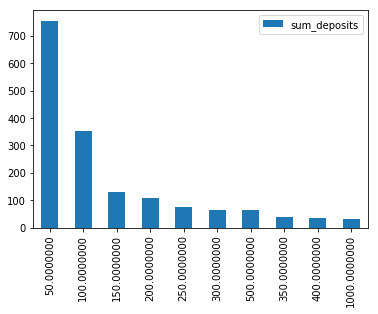

In [30]:
df, plot = column_summary('sum_deposits', 10);
df
plot

,account_type
FUN_BUX,57393
SERIOUS_BUX,1446


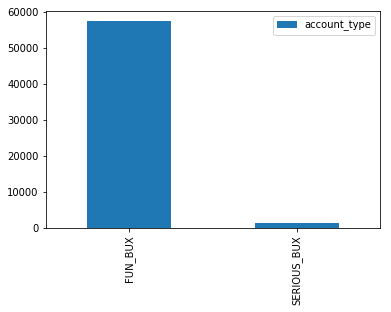

In [31]:
df, plot = column_summary('account_type',10)
df
plot

,network
Facebook Installs,15845
Organic,12553
TV,12314
Viral Invites,10037
Instagram Installs,1913
Appnext,1680
Google Adwords Search,1135
BUX Website,817
AdColony,555
Ligatus,435


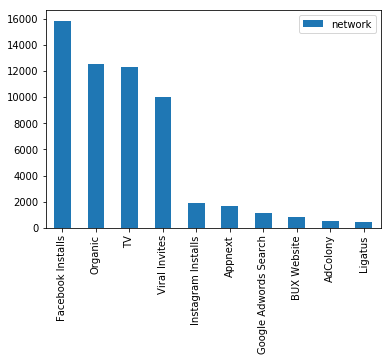

In [32]:
df, plot = column_summary('network',10)
df
plot

,trading_experience
NONE,45581
SOME,13254
EXPERT,4


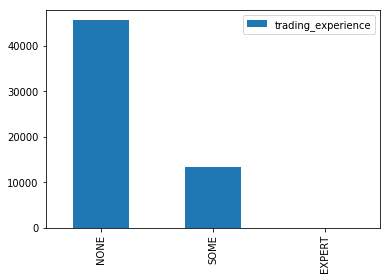

In [33]:
df, plot = column_summary('trading_experience',10)
df
plot

,gender
MALE,7040
FEMALE,402


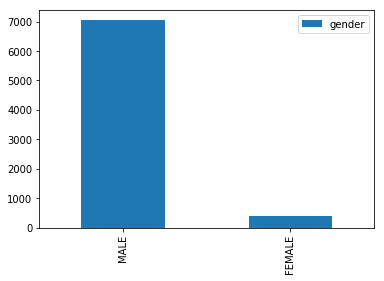

In [34]:
df, plot = column_summary('gender',10)
df
plot

### Transactions (cube_daily_user)

Daily transaction aggragation of user transactions

In [35]:
user_ids = tuple(users['user_id'].unique())

In [36]:
sample_user_ids = tuple(users[:5]['user_id'])
# str(sample_user_ids)
sample_user_ids

('031b0f17-9a45-4b1b-b7b4-027802ffad95',
 '010e236f-8ab5-4681-a146-273531d19d54',
 '011f6526-ab7e-4790-b289-5fa1faf69bc3',
 '0231bd62-6733-4f8b-9c57-87f4eb9e0aa1',
 '028e03b9-ab6d-4ede-85f2-ce6b6e38ad47')

In [37]:
daily_cube_columns = ['user_id', 'day_of_year', 'date', 'number_of_sessions', 'total_session_duration', 'account_status', 'trades_fb_commodities_open', 'trades_fb_commodities_profit', 'social_status_battles', 'social_status', 'conversion_to_sb']
daily_cube_columns = str(tuple(["a." + column for column in daily_cube_columns]))
daily_cube_columns = daily_cube_columns.replace('(', '').replace(')','').replace("'", "")
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

## Query on all users

In [38]:
len(users)

58839

In [39]:
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

In [11]:
# query_transactions = """

#     SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
#     FROM reporting.cube_daily_user a 
#     JOIN reporting.user_details b on b.user_id = a.user_id
#     WHERE b.bux_account_created_dts::date  between '2017-02-01' and '2017-03-01'
#     AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

# """
# query_transactions

In [ ]:
BETWEEN '2016-10-01' AND '2017-09-30'

In [76]:
%%time

query_transactions_large_1 = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  BETWEEN '2016-10-01' AND '2016-12-31'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""

cube_daily_user_large_1 = sql_query(query_transactions_large_1)
cube_daily_user_large_1.head()

CPU times: user 3min 30s, sys: 19.7 s, total: 3min 49s
Wall time: 3min 57s


In [77]:
%%time

query_transactions_large_2 = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  BETWEEN '2017-01-01' AND '2017-03-31'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""

cube_daily_user_large_2 = sql_query(query_transactions_large_2)
cube_daily_user_large_2.head()

CPU times: user 4min 41s, sys: 22.4 s, total: 5min 4s
Wall time: 5min 29s


In [78]:
%%time

query_transactions_large_3 = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  BETWEEN '2017-04-01' AND '2017-06-30'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""

cube_daily_user_large_3 = sql_query(query_transactions_large_3)
cube_daily_user_large_3.head()

CPU times: user 3min 14s, sys: 13.7 s, total: 3min 27s
Wall time: 3min 38s


In [79]:
%%time

query_transactions_large_4 = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  BETWEEN '2017-07-01' AND '2017-09-30'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""

cube_daily_user_large_4 = sql_query(query_transactions_large_4)
cube_daily_user_large_4.head()

CPU times: user 3min 36s, sys: 15.3 s, total: 3min 51s
Wall time: 3min 57s


In [91]:
query_transactions_large_1

"\n\n    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb\n    FROM reporting.cube_daily_user a \n    JOIN reporting.user_details b on b.user_id = a.user_id\n    WHERE b.bux_account_created_dts::date  BETWEEN '2016-10-01' AND '2016-12-31'\n    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'\n    \n\n"

In [92]:
cube_daily_user_large = cube_daily_user_large_1.append(cube_daily_user_large_2).append(cube_daily_user_large_3).append(cube_daily_user_large_4)

In [93]:
len(cube_daily_user_large)

3332705

In [94]:
cube_daily_user_large.to_csv("data/cube_1y_6mCustomerValue.csv")

In [41]:
# conn = vertica_python.connect(**conn_info)
# cur = conn.cursor('dict')
# cur.execute(query_transactions)
# cube_daily_user = pd.DataFrame(cur.fetchall())
# cube_daily_user.head()

,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,000c5e5d-4e25-412d-951b-31167045eb95,60,2017-03-01,0,0,FUN_BUX,0,0.00,0,Following,0
1,000c5e5d-4e25-412d-951b-31167045eb95,61,2017-03-02,0,0,FUN_BUX,0,0.00,0,Following,0
2,000c5e5d-4e25-412d-951b-31167045eb95,62,2017-03-03,0,0,FUN_BUX,0,0.00,0,Following,0
3,000c5e5d-4e25-412d-951b-31167045eb95,65,2017-03-06,0,0,FUN_BUX,0,0.00,0,Following,0
4,000c5e5d-4e25-412d-951b-31167045eb95,66,2017-03-07,0,0,FUN_BUX,0,0.00,0,Following,0


In [46]:
len(cube_daily_user['user_id'].unique())

58045

In [47]:
len(cube_daily_user)

370117

In [48]:
len(cube_daily_user['user_id'].unique())

58045

In [49]:
cube_daily_user.to_csv('data/cube_daily_user_Feb_1_30days_cohort.csv')

In [521]:
pd.Series(cube_daily_user.columns)

0                          user_id
1                      day_of_year
2                             date
3               number_of_sessions
4           total_session_duration
5                   account_status
6       trades_fb_commodities_open
7     trades_fb_commodities_profit
8            social_status_battles
9                    social_status
10                conversion_to_sb
dtype: object

In [523]:
cube_daily_user.groupby('user_id')['number_of_sessions', 'total_session_duration', 'trades_fb_commodities_open'].mean()[0:5]

,number_of_sessions,total_session_duration,trades_fb_commodities_open
user_id,,,
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,1.0,661.0,0.0
00028e09-fcff-4368-9409-e9419efec176,2.0,256.0,0.0
0008181d-5863-4378-ba9a-00206346827b,3.0,8391.0,0.0
000a8509-5100-4f81-9487-85b71f77e2a6,1.2,1658.4,0.0
000ce685-75a4-4490-81a0-2efb786f8c87,2.0,297.5,0.0


## Current customer value (CurCV)

In [141]:
query_curcv_feb17 = """ 

        SELECT a.user_id, sum(b.commission) as com, sum(b.dividend) as div, sum(b.financing_fee) as ff
        FROM (
        
        SELECT user_id
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-03-01') a
        

        LEFT JOIN (
        
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , sum(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , sum(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , sum(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '12 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY a.user_id

"""

CurCV_feb17 = sql_query(query_curcv_feb17)
CurCV_feb17[0:5]

,user_id,com,div,ff
0,3e675443-9762-4137-b92e-3cbcea38e44a,None,None,None
1,0de77d85-f73d-4798-90e2-7bc4de4f74dd,None,None,None
2,6f40a1bf-1d49-4d6a-8c6f-683526189f9e,None,None,None
3,20544428-b6fa-46be-9b82-25d064e3650f,None,None,None
4,076e3239-a377-4cbb-81ed-8f16a3197a5d,None,None,None


In [136]:
query_curcv_1ycohort_6mCurCV = """ 

        SELECT a.user_id, a.bux_account_created_dts, SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2016-10-01' AND '2017-09-30'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2
        ORDER BY 1,2

"""

CurCV_1yCohort_6mCurCV = sql_query(query_curcv_1ycohort_6mCurCV)
CurCV_1yCohort_6mCurCV[0:5]

KeyboardInterrupt: 

In [142]:
len(CurCV_1yCohort_6mCurCV)

565983

In [143]:
# CurCV_feb17['CLV'] = CurCV_feb17['com'] + CurCV_feb17['ff'] # + CurCV_feb17['div'] 
# CurCV_1yCohort_6mCurCV['CLV'] = CurCV_1yCohort_6mCurCV['com'] + CurCV_1yCohort_6mCurCV['ff'] #  CurCV_1yCohort_6mCurCV['div']

In [144]:
CurCV_feb17.to_csv('data/curCv_Feb_1_30days_cohort.csv')
CurCV_1yCohort_6mCurCV.to_csv('data/curCv_1ycohort_6mCurCV.csv')

### Query superbuxer

In [22]:
query_superbuxer = """

SELECT
     COUNT (DISTINCT a.user_id)
FROM
     reporting.user_details a
JOIN
     reporting.user_type b
USING
     (user_id)
WHERE
     year (bux_account_created_dts) = 2018
 AND b.date <= a.bux_account_created_dts + interval '1 year'
 AND b.user_type = 'SuperBUXer'
 
 
"""

super_buxer_unique_count_2016 = sql_query(query_superbuxer)
super_buxer_unique_count_2016[0:5]

,COUNT
0,5


### Distinct BUX classses

In [26]:
query_user_classes = """

SELECT
     DISTINCT b.user_type
FROM
     reporting.user_details a
JOIN
     reporting.user_type b
USING
     (user_id)
WHERE
     year (bux_account_created_dts) = 2017
 AND b.date <= a.bux_account_created_dts + interval '1 year'
 
 
"""

user_classes = sql_query(query_user_classes)
user_classes[0:5]

,user_type
0,SuperBUXer
1,Ex-SeriousBUXer
2,FunBUXer
3,Prospect On Risk
4,SeriousBUXer


### Value of chorts MoM (6 months)

In [108]:
query_mom_curcv = """ 

        SELECT YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), COUNT(DISTINCT a.user_id), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2016-01-01' AND '2017-09-30'
        GROUP BY 1,2) a
        

        LEFT JOIN (
        
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1, 2
        ORDER BY 1,2

"""

CurCV_MoM = sql_query(query_mom_curcv)
CurCV_MoM[0:5]

,YEAR,MONTH,COUNT,com,div,ff
0,2016,1,47303,395593.96,-4963.92,21858.56
1,2016,2,37067,358764.78,-2252.60,25392.09
2,2016,3,35101,428034.48,-2886.60,34571.94
3,2016,4,36521,257482.60,-2837.27,24421.86
4,2016,5,27962,139534.00,-167.60,12828.07


In [114]:
CurCV_MoM["YEAR_MONTH"] = pd.Series([str(row["YEAR"]) + "-0" + str(row["MONTH"])  if row["MONTH"] <= 9 else str(row["YEAR"]) + "-" + str(row["MONTH"]) for index, row in CurCV_MoM.iterrows()])
CurCV_MoM["YEAR_MONTH"] = pd.to_datetime(CurCV_MoM["YEAR_MONTH"])
CurCV_MoM["CLV"] = CurCV_MoM["com"] + CurCV_MoM["ff"] # CurCV_MoM["div"]
CurCV_MoM[["CLV", "com", "div", "ff"]]=CurCV_MoM[["CLV", "com", "div", "ff"]].astype(float)
CurCV_MoM["CLV/user"] = CurCV_MoM["CLV"] / CurCV_MoM["COUNT"]
CurCV_MoM.head()

,YEAR,MONTH,COUNT,com,div,ff,YEAR_MONTH,CLV,CLV/user
0,2016,1,47303,395593.96,-4963.92,21858.56,2016-01-01,417452.52,8.825075
1,2016,2,37067,358764.78,-2252.60,25392.09,2016-02-01,384156.87,10.363851
2,2016,3,35101,428034.48,-2886.60,34571.94,2016-03-01,462606.42,13.179295
3,2016,4,36521,257482.60,-2837.27,24421.86,2016-04-01,281904.46,7.718969
4,2016,5,27962,139534.00,-167.60,12828.07,2016-05-01,152362.07,5.448897


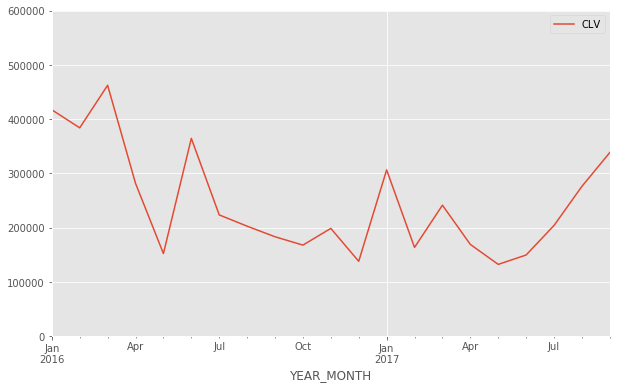

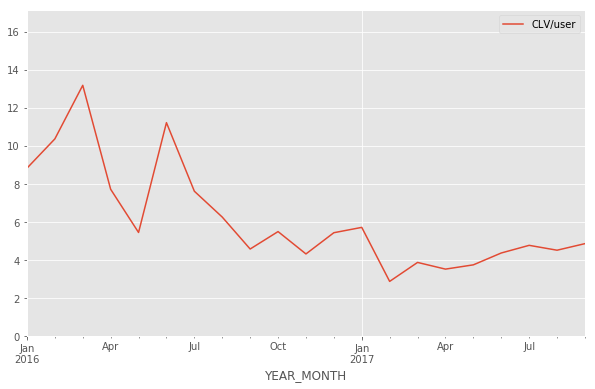

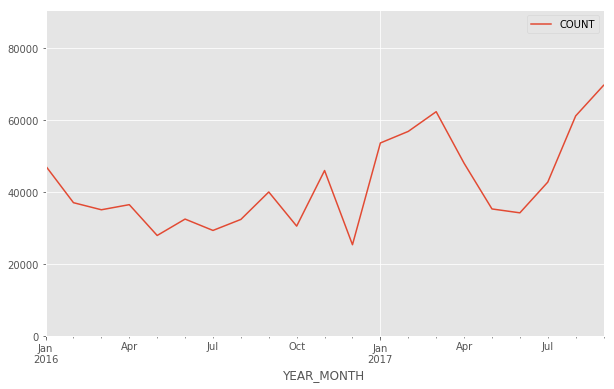

In [115]:
CurCV_MoM.plot(x='YEAR_MONTH', y='CLV', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='CLV/user', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV/user"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='COUNT', figsize=(10,6), ylim=(0,max(CurCV_MoM["COUNT"])*1.3));

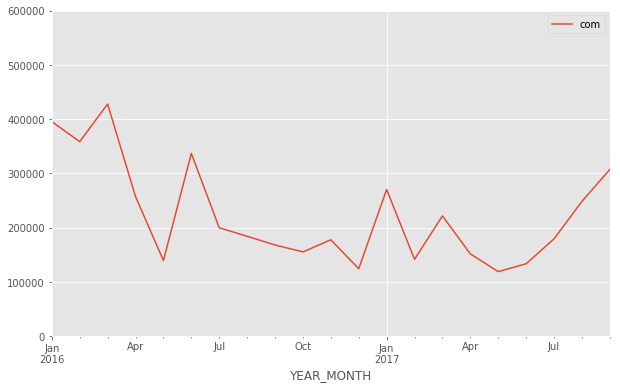

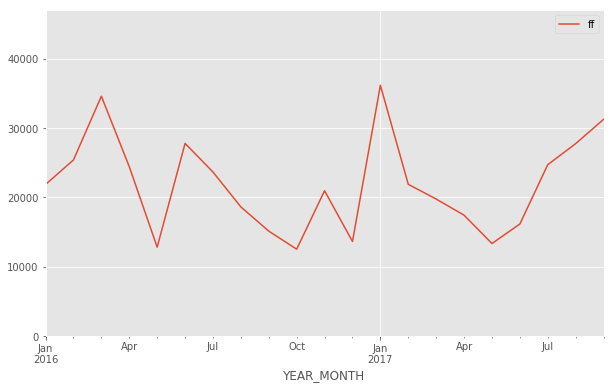

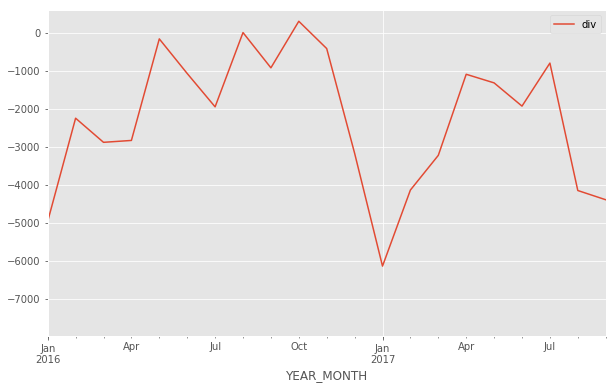

In [116]:
CurCV_MoM.plot(x='YEAR_MONTH', y='com', figsize=(10,6), ylim=(0,max(CurCV_MoM["CLV"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='ff', figsize=(10,6), ylim=(0,max(CurCV_MoM["ff"])*1.3));
CurCV_MoM.plot(x='YEAR_MONTH', y='div', figsize=(10,6), ylim=(min(CurCV_MoM["div"])*1.3,max(CurCV_MoM["div"])*2));

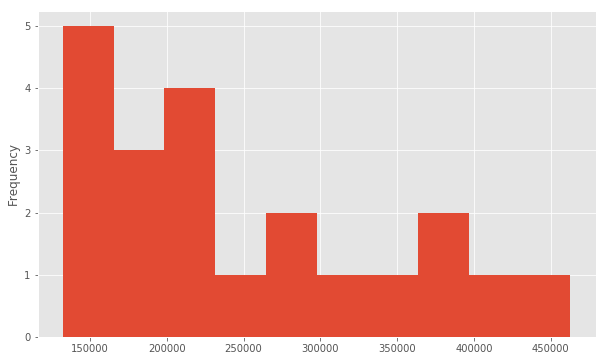

In [112]:
CurCV_MoM["CLV"].plot(kind='hist',bins=10,figsize=(10,6));

In [113]:
CurCV_MoM["CLV"].describe()

count        21.000000
mean     245726.117143
std       98897.728338
min      132421.660000
25%      167950.960000
50%      204179.810000
75%      306650.600000
max      462606.420000
Name: CLV, dtype: float64

#### 50% of 6 month value of monthly cohorts are fall between 170k and 300k

### Distribution of whales MoM

In [100]:
%%time

query_curcv_whales = """ 

        SELECT a.user_id, YEAR(a.bux_account_created_dts), MONTH(a.bux_account_created_dts), SUM(b.commission) as com, SUM(b.dividend) as div, SUM(b.financing_fee) as ff
        FROM (
        
        SELECT user_id, bux_account_created_dts
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-01-01' AND '2017-09-30'
        GROUP BY 1,2) a
        
        LEFT JOIN (
        
        SELECT
        a.user_id
        , created_dts::date as report_date
        , SUM(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , SUM(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , SUM(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        FROM reporting.transactions a
        LEFT JOIN reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        LEFT JOIN reporting.user_details c USING(user_id)
        WHERE a.created_dts < c.bux_account_created_dts + interval '6 months'
        GROUP BY 1,2
        ORDER BY 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY 1,2,3
        ORDER BY 1,2

"""

CurCV_whales = sql_query(query_curcv_whales)
CurCV_whales[0:5]

CPU times: user 55.6 s, sys: 7.92 s, total: 1min 3s
Wall time: 1min 14s


In [101]:
%%time

CurCV_whales["YEAR_MONTH"] = pd.Series([str(row["YEAR"]) + "-0" + str(row["MONTH"])  if row["MONTH"] <= 9 else str(row["YEAR"]) + "-" + str(row["MONTH"]) for index, row in CurCV_whales.iterrows()])

CPU times: user 2min 20s, sys: 333 ms, total: 2min 21s
Wall time: 2min 22s


In [102]:
%%time

CurCV_whales["YEAR_MONTH"] = pd.to_datetime(CurCV_whales["YEAR_MONTH"])
CurCV_whales = CurCV_whales.fillna(0)
CurCV_whales["CLV"] = CurCV_whales["com"] + CurCV_whales["ff"] # + CurCV_whales["div"]
CurCV_whales[["CLV", "com", "div", "ff"]]=CurCV_whales[["CLV", "com", "div", "ff"]].astype(float)
CurCV_whales.head()

CPU times: user 1.67 s, sys: 16 ms, total: 1.68 s
Wall time: 1.72 s


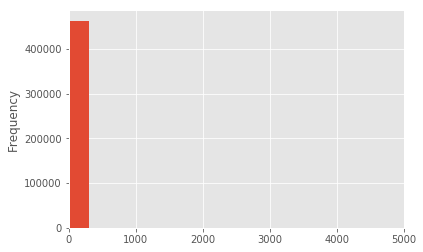

In [103]:
CurCV_whales["CLV"].plot(kind='hist',bins=100, xlim=(0,5000));

In [104]:
len(CurCV_whales[CurCV_whales["CLV"] == 0])

449081

In [105]:
CurCV_whales["CLV"].describe()

count    464028.000000
mean          4.272114
std         133.444258
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       30432.380000
Name: CLV, dtype: float64

In [106]:
whale_threshold = CurCV_whales['CLV'].quantile(0.99)
whale_threshold

35.93

In [107]:
CurCV_whales["YEAR_MONTH"].min(), CurCV_whales["YEAR_MONTH"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-09-01 00:00:00'))

### 6 month whale value threshold:

#### 2016-01 -> 2017-09 = 50 euros, mean = 6 euros, std = 184, 8800 whales
#### 2016-01 -> 2016-12 = 50 euros, mean = 5.8 euros, std = 184, 5000 whales)
#### 2017-01 -> 2017-09 = 

In [294]:
len(CurCV_whales[CurCV_whales["CLV"] > whale_threshold])

5059

In [ ]:
CurCV_whales[CurCV_whales["CLV"] > whale_threshold]["CLV"].plot(kind='bar')

In [ ]:
# pd.DataFrame(serious_buxers).reset_index().hist(cumulative=True, normed=1, bins=100);

In [223]:
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

# Downsampling (later in the pipeline, after splitting train/test)

In [37]:
len(CurCV_1yCohort_6mCurCV)

565983

In [40]:
CurCV_1yCohort_6mCurCV["CLV"] = CurCV_1yCohort_6mCurCV["CLV"].astype(float)
CurCV_1yCohort_6mCurCV = CurCV_1yCohort_6mCurCV.fillna(0)
CurCV_1yCohort_6mCurCV["whale"] = (CurCV_1yCohort_6mCurCV["CLV"] > 50).astype(int)
CurCV_1yCohort_6mCurCV["whale"].value_counts()

0    561372
1      4611
Name: whale, dtype: int64

In [64]:
num_of_whales = len(CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 1])
num_of_whales

4611

In [60]:
CurCV_1yCohort_6mCurCV.sort_values(by="CLV", ascending=False)[0:15]

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
381732,acb6d13f-27f3-420e-8cef-d80fb7813fc2,2017-08-07 19:13:11.542,28269.25,-1302.31,2163.13,29130.07,1,29130.07
492888,df02e3b2-f83f-428f-8bda-c0f5293e6ddb,2016-10-11 05:53:56.543,24997.81,-90.13,603.59,25511.27,1,25511.27
124094,3841e8eb-c047-47b9-b1bb-aa117ca8121d,2017-06-25 10:23:10.752,22839.71,-91.43,1548.12,24296.40,1,24296.40
363591,a48ddf05-9e18-4c05-9514-bbb2de8b304e,2017-09-15 12:02:13.293,22676.53,-25.20,319.18,22970.51,1,22970.51
466948,d363380d-1e19-4c0d-98f5-0c97d6a514b9,2017-03-14 18:38:21.261,20530.05,0.00,1157.35,21687.40,1,21687.40
66173,1dfd5300-f30c-4e99-86bc-b158559e4dfc,2016-12-15 15:34:56.919,20472.92,-1625.86,2207.44,21054.50,1,21054.50
369551,a73a431f-b8f8-4a9c-b839-0091be9e4433,2016-10-12 23:00:48.589,19447.61,11.26,184.08,19642.95,1,19642.95
83251,25cf9821-ddb1-4c66-861d-bcc30b6d49c0,2017-01-13 20:10:43.712,11878.21,1308.34,5065.89,18252.44,1,18252.44
323265,923492d8-d04e-49a1-9c60-8c95d4597d4c,2016-11-07 00:22:56.164,14303.56,8.57,860.87,15173.00,1,15173.00
201655,5b484d6e-9003-4878-95b3-bd20e4bbdbab,2017-09-09 14:35:04.904,14076.76,-795.11,1616.62,14898.27,1,14898.27


In [96]:
CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["CLV"] < -100]

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
277645,7d903ec2-62fb-4461-860a-6b61fa94c0dc,2017-05-09 20:25:26.566,35.30,-402.13,74.90,-291.93,0,-291.93
418226,bd50b13a-3890-4b15-b7c5-7fe3c534e4ba,2017-01-25 13:36:23.838,1996.15,-5652.77,792.31,-2864.31,0,-2864.31


In [44]:
CurCV_1yCohort_6mCurCV["CLV"].describe()

count    565983.000000
mean          4.340459
std         137.687575
min       -2864.310000
25%           0.000000
50%           0.000000
75%           0.000000
max       29130.070000
Name: CLV, dtype: float64

In [42]:
CurCV_1yCohort_6mCurCV.head()

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
0,00001025-a69f-498c-be1e-6fc4ec96453b,2016-10-01 07:48:23.647,0,0,0,0,0,0.0
1,00001e00-0bc0-4de5-a212-c19a9afe0dc0,2017-08-21 07:05:33.269,0,0,0,0,0,0.0
2,00003ad5-d62d-4a88-ae32-558b9ac70915,2017-01-22 18:43:34.760,0,0,0,0,0,0.0
3,0000656b-8703-4505-917d-652b80545a1f,2017-09-28 11:04:33.659,0,0,0,0,0,0.0
4,00008058-2e3f-42dd-a9d7-8ee371d876ab,2017-05-10 13:26:35.931,0,0,0,0,0,0.0


In [69]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 0]
df_minority = CurCV_1yCohort_6mCurCV[CurCV_1yCohort_6mCurCV["whale"] == 1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_of_whales*10,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled["whale"].value_counts()

0    46110
1     4611
Name: whale, dtype: int64

In [70]:
df_downsampled

,user_id,bux_account_created_dts,com,div,ff,total,whale,CLV
305729,8a35d43b-b4be-4c0c-82c1-bee7b760bd87,2016-12-26 13:20:05.768,0,0,0,0,0,0.00
262165,76a63b6c-b839-4940-a09d-f3c7d312eaaa,2017-09-15 17:23:47.783,0,0,0,0,0,0.00
379319,aba37f50-7dd7-43e4-8110-557c892b90b1,2016-11-01 14:51:27.960,0,0,0,0,0,0.00
220680,64095894-06e8-49bf-a265-a9ac02bb8d29,2017-05-15 17:34:36.036,0,0,0,0,0,0.00
147611,42e702f2-a492-43fd-8e45-13fa53f4a351,2017-07-24 18:36:57.613,0,0,0,0,0,0.00
316664,8f3c08f8-d9b8-469a-a43f-af4947c7c325,2016-10-19 19:54:50.773,0,0,0,0,0,0.00
137602,3e549c63-b57d-4a8e-8db7-b5440dd4b25d,2017-04-17 17:17:26.015,0,0,0,0,0,0.00
324149,9297cc15-ed40-464a-850b-447ea5405f60,2016-12-27 23:55:21.909,0,0,0,0,0,0.00
348172,9d8548ae-d4da-4e4c-8398-499ebd5e892b,2017-01-02 12:03:34.071,0,0,0,0,0,0.00
254209,730c54b2-8b55-4a4f-b696-fb5f81226a1c,2017-02-14 20:02:47.074,0,0,0,0,0,0.00
